# Tutorial: CommonRoad Search 
## Graph Search-Based Motion Planners with Motion Primitives

This tutorial shows how [CommonRoad Search](https://gitlab.lrz.de/tum-cps/commonroad-search), or **Graph Search-Based Motion Planner with Motion Primitives**, is used to search for trajectories that connect an **initial state** and a **goal region**.

## 0. Preparation
* Before you proceed, make sure you have read through the tutorial for [CommonRoad-io](https://commonroad.in.tum.de/static/docs/commonroad-io/index.html). Its tutorial can be found [here](https://commonroad.in.tum.de/tutorials/).
* Make sure you have installed all necessary modules for CommonRoad Search according to the installation manual.
* A documentation for the API of CommonRoad Search can be found [here](https://commonroad.in.tum.de/static/docs/commonroad-search/index.html).
* The API of CommonRoad-io can be found [here](https://commonroad.in.tum.de/static/docs/commonroad-io/api/index.html)

## 1. Load Python Environment
We first import necessary modules for motion planning, as well as some extensions for our convenience.

In [1]:
# enabling autoreload will reload modules automatically before entering the execution of code,
# so you could edit the code for your motion planner and execute it right away without reloading again
%load_ext autoreload
%autoreload 2

# always show execution time for each cell
%load_ext autotime

# use notebook to get interactive plots
%matplotlib notebook

In [2]:
# append main directory
import sys
sys.path.append("../../GSMP/motion_automata")

# load necessary modules and functions
from automata.HelperFunctions import *

time: 327 ms


Secondly, we specify the motion planner that we want to use:

In [3]:
# Uncomment the following to try out exemplary motion planners

# Greedy Best First Search
from automata.MotionPlanner_gbfs import MotionPlanner

# A* search
# from automata.MotionPlanner_Astar import MotionPlanner

# Uncomment the following to load your own motion planner

# from automata.MotionPlanner import MotionPlanner

time: 7.51 ms


## 2. Load Scenarios
We call automata.HelperFunctions.load_scenario() to load scenarios and planning problems. Scenarios beginning with letter C stand for cooeprative driving scenarios and possess multiple planning problems. In this case you should provide solutions to all planning problems.

<IPython.core.display.Javascript object>


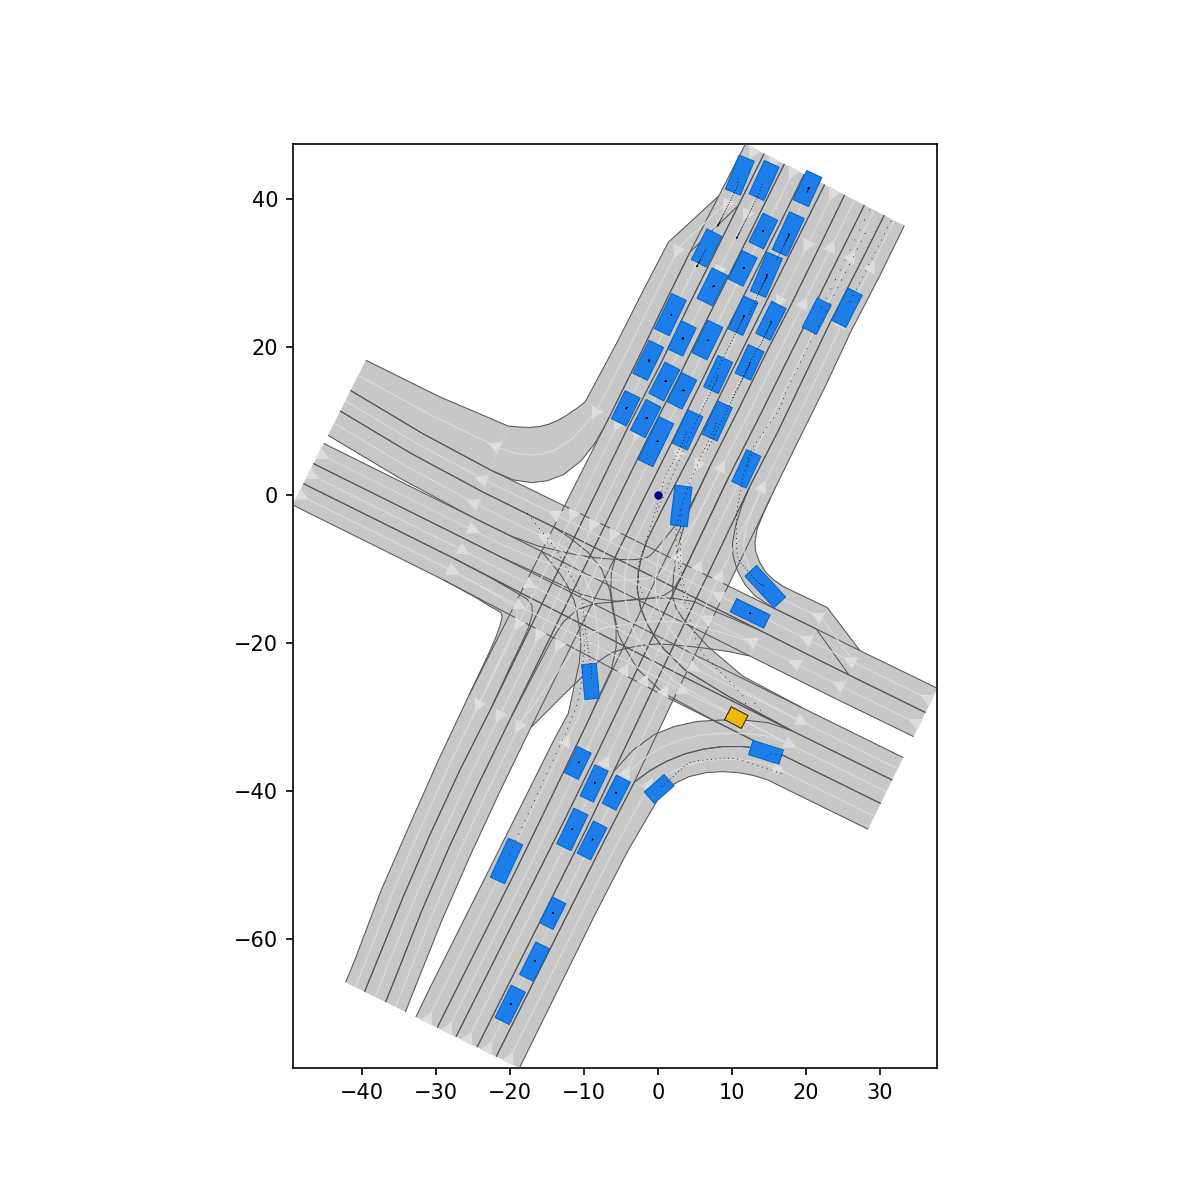

time: 425 ms


In [4]:
scenario_path_prefix = '../../scenarios/exercise/'
scenario_id = 'USA_Lanker-1_2_T-1'
# construct file path
scenario_path = scenario_path_prefix + scenario_id + '.xml'

scenario, planning_problem_set = load_scenario(scenario_path)

# plot the scenario and planning problem set
plt.figure(figsize=(8, 8))
draw_object(scenario)
draw_object(planning_problem_set)
plt.gca().set_aspect('equal')
plt.margins(0,0)
plt.show()

## 3. Load Motion Primitives
We call automata.HelperFunctions.generate_automata() to generate a motion automata instance.

The variable veh_type_id specifies the id of the vehicle model that we want to use:

1: FORD_ESCORT

2: BMW320i

3: VW_VANAGON

In [5]:
veh_type_id = 2

if veh_type_id   == 1: veh_type = VehicleType.FORD_ESCORT
elif veh_type_id == 2: veh_type = VehicleType.BMW_320i
elif veh_type_id == 3: veh_type = VehicleType.VW_VANAGON
    
automata = generate_automata(veh_type_id)

Reading motion primitives...
Automata created.
Number of loaded primitives: 3066
time: 3.32 s


## 4. Initialize Motion Planner

In this step, we would like to configure the planning problem for the motion planner. Each **planning problem** has an individual **initial state** and a **goal region**.

In [ ]:
# retrieve planning problem with given index (for cooperative scenario:0, 1, 2, ..., otherwise: 0)
planning_problem_idx = 0
planning_problem = list(planning_problem_set.planning_problem_dict.values())[planning_problem_idx]

# add initial state of planning problem to automata
automata, initial_motion_primitive = add_initial_state_to_automata(automata, planning_problem)

# construct motion planner.
motion_planner = MotionPlanner(scenario, planning_problem, automata)

## 5. Search for Solution
We call automata.HelperFunctions.start_search() to start searching for a feasible solution base on the given motion planner.

In [ ]:
result_path, result_dict_status = start_search(scenario,
                                               planning_problem, 
                                               automata,
                                               motion_planner, 
                                               initial_motion_primitive)

## 6. Visualize Planned Trajectory
Given that we have found a feasible solution, we can also create an interactive visualizor for the solution.
We define two helper functions to retrieve state and its collision object at a given time step:

In [ ]:
def get_state_at_time(t):
    for state in result_path:
        # return the first state that has time_step >= given t
        if state.time_step >= t:
            return state
    # else return last state
    return path[-1]

def draw_state(t):
    print("current time step: ", t)
    plt.clf()
    draw_object(scenario, draw_params={'time_begin': t})
    draw_object(planning_problem)
    plt.gca().set_aspect('equal')
    plt.gca().set_axis_off()
    plt.margins(0,0)
    plt.show()

    if result_path is not None:
        state = get_state_at_time(t)
        trajectory = Trajectory(initial_time_step=int(state.time_step),state_list=[state])
        prediction = TrajectoryPrediction(trajectory=trajectory, shape=automata.egoShape)
        collision_object = create_collision_object(prediction)
        draw_it(collision_object)

In [ ]:
fig = plt.figure(figsize=(8,8))

# use the slider to have at look at every time step of the planned trajectory
widgets.interact(draw_state, t=widgets.IntSlider(min=0,max=result_path[-1].time_step,step=1,value=0))

In [ ]:
# if you wish to visualize the final trajectory
if len(result_dict_status['path_current']) > 0:
    plt.figure(figsize=(8, 8))
    plt.clf()
    draw_object(scenario)
    draw_object(planning_problem)
    plt.gca().set_aspect('equal')
    plt.gca().set_axis_off()
    plt.margins(0,0)
    plt.show()
    
    trajectory = Trajectory(0, result_dict_status['path_current'][0:])
    prediction = TrajectoryPrediction(trajectory=trajectory, shape=automata.egoShape)
    collision_object = create_collision_object(prediction)
    draw_it(collision_object, draw_params={'collision': {'facecolor': 'green'}})
 

In [ ]:
# if you wish to print out individual state
# for state in result_path:
#     print(state)

## 7. Write Solution to CommonRoad XML File
The final step is writing your solution to the planning problem in the scenario into an XML file which is uploadable to our [Benchmark](https://commonroad.in.tum.de/submissions/create).
You may also refer to [Solution Writer](https://commonroad.in.tum.de/static/docs/commonroad-io/api/common.html#module-commonroad.common.solution_writer), [Cost Function](https://gitlab.lrz.de/tum-cps/commonroad-cost-functions/blob/master/costFunctions_commonRoad.pdf) and [Vehicle Model](https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/blob/master/vehicleModels_commonRoad.pdf) for additional information.
Note: In this tutorial we use Kinematic Single-Track Model.

In [ ]:
list_state = list()

for state in result_path:
    kwarg = {'position': state.position, 
             'velocity': state.velocity,
             'steering_angle': state.steering_angle, 
             'orientation': state.orientation, 
             'time_step': state.time_step}
    list_state.append(State(**kwarg))

trajectory = Trajectory(initial_time_step=list_state[0].time_step, state_list=list_state)

In [ ]:
from commonroad.common.solution_writer import CommonRoadSolutionWriter, VehicleModel, VehicleType, CostFunction
output_dir="../../solutions/"

# write solution to a xml file
csw = CommonRoadSolutionWriter(output_dir=output_dir,                   # output directory
                               scenario_id=scenario_id,                 # scenario id
                               step_size=0.1,                           # time step of scenario, typically 0.1
                               vehicle_type=veh_type,                   # vehicle type, change if needed
                               vehicle_model=VehicleModel.KS,           # vehicle model, change if needed
                               cost_function=CostFunction.SM1)          # cost funtion, ** do not use JB1 **

# add trajectory solution
csw.add_solution_trajectory(trajectory=trajectory, planning_problem_id=planning_problem.planning_problem_id)

csw.write_to_file(overwrite=True)